In [76]:
!Rscript ./create_synthetic_dataset.r

Error in library(tidyverse) : there is no package called ‘tidyverse’
Execution halted


In [256]:
import pandas as pd
import numpy as np

df_counts_mrna = pd.read_csv("../data/sd_counts_mrna.csv", index_col=0)
df_cell_info = pd.read_csv("../data/sd_cell_info.csv", index_col="cell_id")
df_feature_info = pd.read_csv("../data/sd_feature_info.csv", index_col=0)
df_expression_patterns= pd.read_csv("../data/sd_expression_patterns.csv", index_col=0)
df_feature_network = pd.read_csv("../data/sd_feature_network.csv", index_col=0)

In [257]:
df_counts_mrna.head()

,Burn1_TF1,Burn2_TF1,Burn3_TF1,Burn4_TF1,A1_TF1,A2_TF1,A3_TF1,A4_TF1,A5_TF1,A6_TF1,...,HK41,HK42,HK43,HK44,HK45,HK46,HK47,HK48,HK49,HK50
cell1,7017,4214,405,6391,2226,928,2595,1938,6194,521,...,0,7303,0,0,0,0,0,0,0,0
cell2,5632,5978,1200,7896,3428,1538,1350,2951,6709,1500,...,0,9770,0,0,0,0,0,0,0,0
cell3,4897,6609,399,10649,3717,1765,3279,3765,4025,400,...,0,9495,0,0,0,0,0,0,0,0
cell4,4336,7817,347,3275,2396,994,2615,2488,5737,1512,...,0,12299,0,0,0,0,0,0,0,0
cell5,6513,4378,325,5031,3804,980,2022,4327,4765,451,...,0,8427,0,8,0,0,0,0,0,0


In [258]:
df_cell_info["transition"] = df_cell_info["from"] + "-" + df_cell_info["to"]
df_cell_info["state"] = df_cell_info["from"]
df_cell_info["time_transition_cell"] = df_cell_info["time"]
df_cell_info = df_cell_info[["transition", "time_transition_cell", "sim_time", "state"]]
df_cell_info.head()

,transition,time_transition_cell,sim_time,state
cell_id,,,,
cell1,sBmid-sD,0.229297,192.000000,sBmid
cell2,sBmid-sD,0.437428,786.000000,sBmid
cell3,sBmid-sD,0.865949,830.000000,sBmid
cell4,sB-sBmid,0.843591,158.000000,sB
cell5,sC-sEndC,0.437135,420.083333,sC


In [259]:
from_state = df_expression_patterns["from"]
to_state = df_expression_patterns["to"]

state_labels = pd.unique(pd.concat([from_state, to_state]))
num_states = state_labels.size
state_trajectory = pd.DataFrame(
    np.zeros((num_states, num_states), dtype=np.int8),
    index=state_labels, 
    columns=state_labels
) 

for from_, to_ in zip(from_state, to_state):
    state_trajectory.loc[from_, to_] = 1 

display(state_trajectory)

,sBurn,sA,sB,sBmid,sC,sD,sEndC,sEndD
sBurn,0,1,0,0,0,0,0,0
sA,0,0,1,0,0,0,0,0
sB,0,0,0,1,0,0,0,0
sBmid,0,0,0,0,1,1,0,0
sC,0,0,0,0,0,0,1,0
sD,0,0,0,0,0,0,0,1
sEndC,0,0,0,0,0,0,0,0
sEndD,0,0,0,0,0,0,0,0


In [260]:
df_expression_patterns

,from,to,module_progression,start,burn,time
1,sBurn,sA,"+Burn1,+Burn2,+Burn3,+Burn4,+B4,+B5",True,True,120
2,sA,sB,"+A1,+A2,+A3,+A4,+A5,+A6",False,False,180
3,sB,sBmid,"+B1,+B4,+B5",False,False,40
4,sBmid,sC,"+B2,+B6,+B8,+B9,+B10,+B11",False,False,120
5,sBmid,sD,"+B3,+B7,+B8,+B12,+B13,+B14",False,False,120
6,sC,sEndC,"+C1,+C2,+C3,+C4,+C5",False,False,149
7,sD,sEndD,"+D1,+D2,+D3,+D4,+D5,+D6",False,False,179


In [261]:
import re

def parse_modules(module_progression: str):
    return re.findall(r"[+-]([a-zA-Z0-9]+)\,?", module_progression) 

transition_modules = {
    f"{row['from']}-{row['to']}": parse_modules(row["module_progression"]) 
    for _, row in df_expression_patterns.iterrows()
}
print(transition_modules)

{'sBurn-sA': ['Burn1', 'Burn2', 'Burn3', 'Burn4', 'B4', 'B5'], 'sA-sB': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6'], 'sB-sBmid': ['B1', 'B4', 'B5'], 'sBmid-sC': ['B2', 'B6', 'B8', 'B9', 'B10', 'B11'], 'sBmid-sD': ['B3', 'B7', 'B8', 'B12', 'B13', 'B14'], 'sC-sEndC': ['C1', 'C2', 'C3', 'C4', 'C5'], 'sD-sEndD': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']}


In [262]:
tf_mask = df_feature_info["is_tf"]
driver_genes = df_feature_info[tf_mask]
display(driver_genes.head())

target_mask = ~df_feature_info["is_tf"] & ~df_feature_info["is_hk"] 
target_genes = df_feature_info[target_mask]
display(target_genes.head())

,feature_id,module_id,basal,burn,independence,color,is_tf,is_hk,transcription_rate,splicing_rate,...,mrna_halflife,protein_halflife,mrna_decay_rate,protein_decay_rate,max_premrna,max_mrna,max_protein,mol_premrna,mol_mrna,mol_protein
1,Burn1_TF1,Burn1,1.0,True,1.0,#FF9999,True,False,15.078484,0.346574,...,3.745472,5.505012,0.185063,0.125912,28.362406,53.115298,45057.880234,mol_premrna_Burn1_TF1,mol_mrna_Burn1_TF1,mol_protein_Burn1_TF1
2,Burn2_TF1,Burn2,0.0,True,1.0,#FF6666,True,False,15.809626,0.346574,...,4.458086,7.187736,0.155481,0.096435,31.489862,70.192262,98879.942545,mol_premrna_Burn2_TF1,mol_mrna_Burn2_TF1,mol_protein_Burn2_TF1
3,Burn3_TF1,Burn3,0.0,True,1.0,#FF3333,True,False,10.103373,0.346574,...,2.700786,7.864742,0.256646,0.088133,16.749066,22.617822,25949.141879,mol_premrna_Burn3_TF1,mol_mrna_Burn3_TF1,mol_protein_Burn3_TF1
4,Burn4_TF1,Burn4,0.0,True,1.0,#FF0000,True,False,17.580155,0.346574,...,4.765104,8.321074,0.145463,0.083300,35.729354,85.127047,148073.563300,mol_premrna_Burn4_TF1,mol_mrna_Burn4_TF1,mol_protein_Burn4_TF1
5,A1_TF1,A1,0.0,False,1.0,#EBFF99,True,False,14.005805,0.346574,...,4.397151,9.036121,0.157636,0.076708,27.777770,61.071521,112184.088676,mol_premrna_A1_TF1,mol_mrna_A1_TF1,mol_protein_A1_TF1


,feature_id,module_id,basal,burn,independence,color,is_tf,is_hk,transcription_rate,splicing_rate,...,mrna_halflife,protein_halflife,mrna_decay_rate,protein_decay_rate,max_premrna,max_mrna,max_protein,mol_premrna,mol_mrna,mol_protein
36,Target1,NaN,0.0001,True,1.0,NaN,False,False,19.016940,0.346574,...,4.301555,7.401595,0.161139,0.093648,37.456133,80.559812,118614.039031,mol_premrna_Target1,mol_mrna_Target1,mol_protein_Target1
37,Target2,NaN,0.0001,True,1.0,NaN,False,False,17.584913,0.346574,...,4.764012,7.862192,0.145497,0.088162,35.736602,85.124804,105154.998974,mol_premrna_Target2,mol_mrna_Target2,mol_protein_Target2
38,Target3,NaN,0.0001,True,1.0,NaN,False,False,13.659622,0.346574,...,3.494387,6.808033,0.198360,0.101813,25.066573,43.796154,46961.466714,mol_premrna_Target3,mol_mrna_Target3,mol_protein_Target3
39,Target4,NaN,0.0001,True,1.0,NaN,False,False,14.543400,0.346574,...,4.076601,5.997727,0.170031,0.115568,28.151917,57.382066,69694.917324,mol_premrna_Target4,mol_mrna_Target4,mol_protein_Target4
40,Target5,NaN,0.5000,True,1.0,NaN,False,False,12.593651,0.346574,...,2.907140,6.960513,0.238429,0.099583,21.527506,31.291740,39446.123663,mol_premrna_Target5,mol_mrna_Target5,mol_protein_Target5


In [263]:
transition_grns = {}
feature_ids = df_feature_info["feature_id"]

for transition, modules in transition_modules.items():
    active_gene_mask = df_feature_info["module_id"].isin(modules)
    active_gene_labels = feature_ids[active_gene_mask]
    active_relations = df_feature_network[df_feature_network["from"].isin(active_gene_labels)]
    transition_grn = pd.DataFrame(
        np.zeros((feature_ids.size, feature_ids.size)),
        index=feature_ids, 
        columns=feature_ids, 
    )
    for _, row in active_relations.iterrows():
        transition_grn.loc[row["from"], row["to"]] = row["effect"] * row["strength"]

    transition_grns[transition] = transition_grn
display(transition_grns["sA-sB"].head())

feature_id,Burn1_TF1,Burn2_TF1,Burn3_TF1,Burn4_TF1,A1_TF1,A2_TF1,A3_TF1,A4_TF1,A5_TF1,A6_TF1,...,HK41,HK42,HK43,HK44,HK45,HK46,HK47,HK48,HK49,HK50
feature_id,,,,,,,,,,,,,,,,,,,,,
Burn1_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Burn2_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Burn3_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Burn4_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
import anndata

adata = anndata.AnnData(X=df_counts_mrna, obs=df_cell_info,  varp=transition_grns, uns={ "state_trajectory": state_trajectory })
adata

AnnData object with n_obs × n_vars = 1000 × 135
    obs: 'transition', 'time_transition_cell', 'sim_time', 'state'
    uns: 'state_trajectory'
    varp: 'sBurn-sA', 'sA-sB', 'sB-sBmid', 'sBmid-sC', 'sBmid-sD', 'sC-sEndC', 'sD-sEndD'

In [265]:
import scanpy as sc

sc.pp.recipe_zheng17(adata, n_top_genes=100)

/home/atr0x/Documents/UNI/WS2025/BachelorArbeit/GAE-gene-interactions/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_recipes.py:187: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(


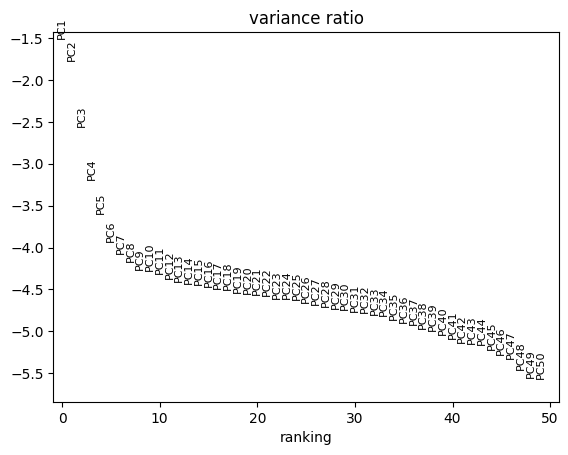

In [266]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [267]:
n_pcs = 30 
sc.pp.neighbors(adata, n_pcs=n_pcs)
sc.tl.umap(adata)

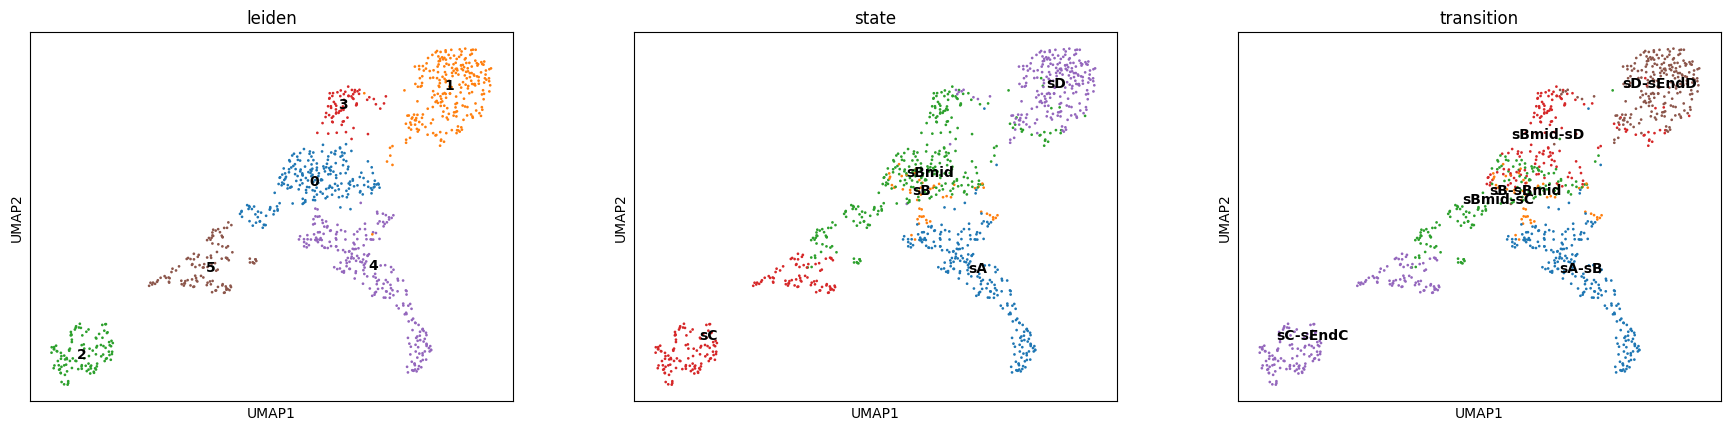

In [268]:
sc.tl.leiden(adata, resolution=0.15, flavor="igraph")
sc.pl.umap(
    adata,
    color=["leiden", "state", "transition"],
    size=15,
    legend_loc="on data"
)

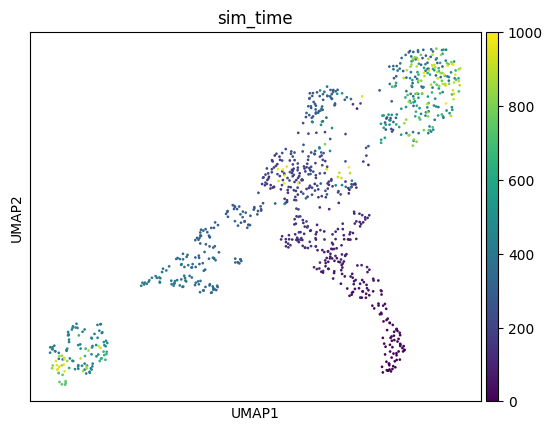

In [269]:
adata.uns["iroot"] = adata.obs["sim_time"].argmin() # I do not know the root, but probably some of the first cells.
sc.pl.umap(
    adata,
    color=["sim_time"],
    size=15
)

In [270]:
transition_names = transition_modules.keys()

transition_clusters = adata.obs["transition"]
time_transition_cell = adata.obs["time_transition_cell"]
splitted_transition_clusters = np.empty_like(transition_clusters)
for transition_name in transition_names:
    transition_indices = np.reshape(np.argwhere(transition_clusters == transition_name), -1)
    if transition_indices.size == 0:
        continue # skip if cluster empty. Happens for sBurn-sA. Because Burn cells are removed from the final data set
    time_transition = time_transition_cell.iloc[transition_indices]
    split_median_mask = time_transition >= time_transition_cell.median()
    indices_split_top = transition_indices[split_median_mask]
    indices_split_bottom = transition_indices[~split_median_mask]

    splitted_transition_clusters[indices_split_bottom] = transition_name + "-from"
    splitted_transition_clusters[indices_split_top] = transition_name + "-to"

adata.obs["splitted_transition"] = pd.Categorical(splitted_transition_clusters)

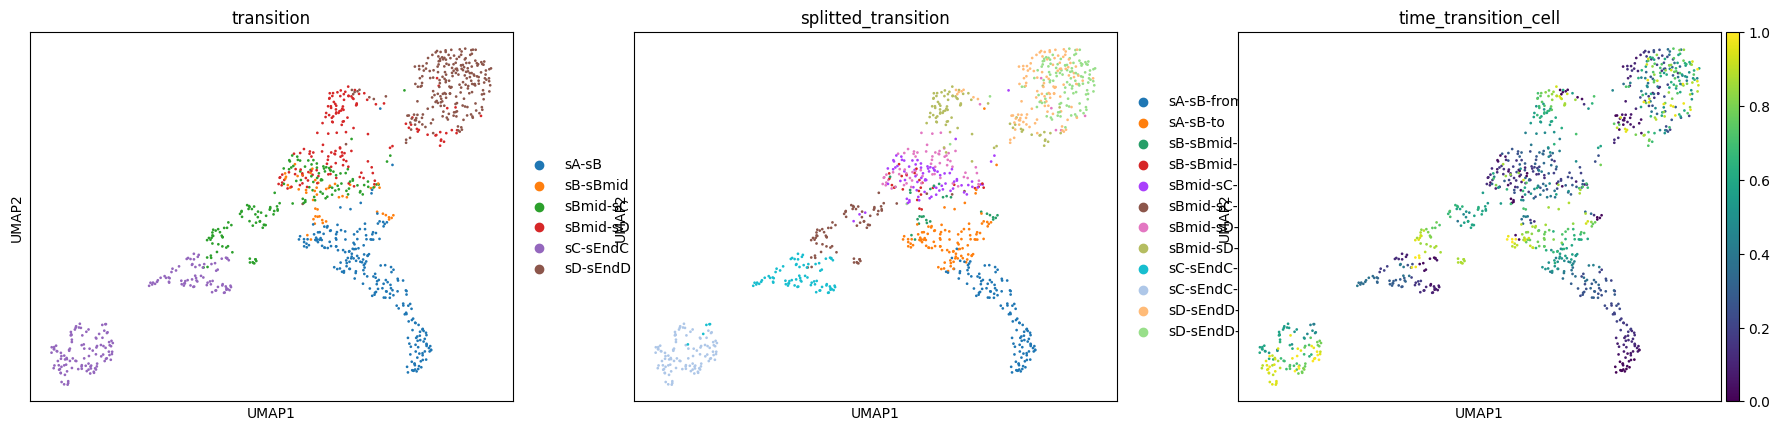

In [271]:
sc.pl.umap(
    adata,
    color=["transition", "splitted_transition", "time_transition_cell"],
    size=15
)

In [272]:
adata

AnnData object with n_obs × n_vars = 1000 × 99
    obs: 'transition', 'time_transition_cell', 'sim_time', 'state', 'n_counts_all', 'leiden', 'splitted_transition'
    var: 'n_counts', 'mean', 'std'
    uns: 'state_trajectory', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'state_colors', 'transition_colors', 'iroot', 'splitted_transition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
    varp: 'sBurn-sA', 'sA-sB', 'sB-sBmid', 'sBmid-sC', 'sBmid-sD', 'sC-sEndC', 'sD-sEndD'

In [273]:
adata.write_h5ad("../data/synthetic_dataset.hda5")